# Word Shift Graphs

DS 5001 Text as Data

- See https://ryanjgallagher.github.io/code/word_shift/overview and https://shifterator.readthedocs.io/en/latest/
- See also SocialSent lexicon https://nlp.stanford.edu/projects/socialsent/

NOTE:

Shifterator code is local and patched in `plotting.py` at line $802$:

```python
tick.label.set_fontsize(12)
```
changed to:
```python
tick.label1.set_fontsize(12)
```
due to changes in Matplotlib.


# Imports

In [71]:
import pandas as pd
import shifterator as sh # NOTE THIS IS LOCAL AND PATCHED 
import plotly_express as px

In [102]:
import warnings
warnings.filterwarnings("ignore", message="FixedFormatter should only be used together with FixedLocator", category=UserWarning)

# Config

In [69]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [103]:
corpus_prefix = 'austen-melville'

# Get Data

In [109]:
SALEX = pd.read_csv(f"{data_home}/lexicons/salex_nrc.csv").set_index('term_str')

In [110]:
SALEX.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,nrc_sentiment
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1


In [111]:
BOW = pd.read_csv(f"{output_dir}/{corpus_prefix}-BOW-CHAPS.csv").set_index(['book_id','chap_id','term_str'])

In [112]:
BOW.head()

n        tf     tfidf
book_id chap_id term_str                       
105     1       1         2  0.000762  0.005048
                15        1  0.000381  0.003509
                16        1  0.000381  0.003890
                1760      1  0.000381  0.003890
                1784      1  0.000381  0.003890

In [113]:
LIB = pd.read_csv(f"{output_dir}/{corpus_prefix}-LIB_LABELS.csv").set_index(['book_id'])
LIB['author_id'] = LIB.author.str.split(', ').str[0]
LIB['book_label'] = LIB.author_id + ' ' + LIB.index.astype('str') + ': ' + LIB.title.str[:20]

In [204]:
LIB.head()

,source_file_path,author,title,chap_regex,book_len,n_chaps,label,y_raw_2,y_L0_2,y_L1_2,y_L2_2,y_raw_4,y_L0_4,y_L1_4,y_L2_4,kendall_sum,author_id,book_label
book_id,,,,,,,,,,,,,,,,,,
105,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,Austen: Persuasion (105),0,1,1,1,2,0,3,2,7.020240,AUSTEN,AUSTEN 105: PERSUASION
121,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,Austen: Northanger Abbey (121),0,1,1,1,2,0,2,2,7.039617,AUSTEN,AUSTEN 121: NORTHANGER ABBEY
141,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,Austen: Mansfield Park (141),0,0,1,1,2,0,3,2,7.021093,AUSTEN,AUSTEN 141: MANSFIELD PARK
158,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,Austen: Emma (158),0,1,1,1,2,0,3,2,6.974829,AUSTEN,AUSTEN 158: EMMA
161,/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50,Austen: Sense And Sensibilit (161),0,1,1,1,2,0,3,2,7.145034,AUSTEN,AUSTEN 161: SENSE AND SENSIBILIT


# Combine Tables

We want to use the word shift diagrams to compare Austen and Melville.

So, we create a table that combines the language models of the two authors along with sentiment values.

In [115]:
AUTH = BOW.join(LIB.author_id, on='book_id')\
    .groupby(['author_id','term_str'])\
    .agg({'n':'sum', 'tfidf':'mean'})\
    .join(SALEX.nrc_sentiment, on='term_str').dropna()

We compute the sentiment contribution of each word for each author.

In [116]:
AUTH['sent_weight'] = AUTH['n'] * AUTH['tfidf'] * AUTH['nrc_sentiment']

In [117]:
AUTH

n     tfidf  nrc_sentiment  sent_weight
author_id term_str                                             
AUSTEN    abandoned     5  0.001997           -1.0    -0.009987
          abhor         7  0.008780           -1.0    -0.061460
          abhorrent     2  0.003259           -1.0    -0.006519
          abolish       1  0.001795           -1.0    -0.001795
          abominable   18  0.003095           -1.0    -0.055704
...                   ...       ...            ...          ...
MELVILLE  young       658  0.001557            1.0     1.024226
          youth       163  0.003000            1.0     0.488932
          zeal         15  0.002686            1.0     0.040295
          zealous       5  0.003046            1.0     0.015229
          zest          4  0.005645            1.0     0.022578

[4854 rows x 4 columns]

# Shifterator Graphs

Check out functions in Shifterator ...

In [120]:
[item for item in sh.__dir__() if '__' not in item]

['helper',
 'plotting',
 'shifterator',
 'Shift',
 'entropy',
 'shifts',
 'EntropyShift',
 'JSDivergenceShift',
 'KLDivergenceShift',
 'ProportionShift',
 'WeightedAvgShift',
 'name']

Convert data into dictionaries for Shifterator

## By Frequency

In [252]:
FREQ = AUTH.n.unstack().T.dropna() # This ensures both have the same words
AFREQ = FREQ['AUSTEN'].to_dict()
MFREQ = FREQ['MELVILLE'].to_dict()

In [260]:
FREQ

author_id,AUSTEN,MELVILLE
term_str,,
abandoned,5.0,67.0
abhor,7.0,4.0
abhorrent,2.0,9.0
abolish,1.0,2.0
abominable,18.0,16.0
...,...,...
yearning,2.0,8.0
young,827.0,658.0
youth,66.0,163.0


In [253]:
SENTW = AUTH.sent_weight.unstack().T.dropna()
ASENTW = SENTW['AUSTEN'].to_dict()
MSENTW = SENTW['MELVILLE'].to_dict()

In [261]:
SENTW

author_id,AUSTEN,MELVILLE
term_str,,
abandoned,-0.009987,-0.233382
abhor,-0.061460,-0.009904
abhorrent,-0.006519,-0.030404
abolish,-0.001795,-0.007523
abominable,-0.055704,-0.060141
...,...,...
yearning,0.000000,0.000000
young,1.377710,1.024226
youth,0.145913,0.488932


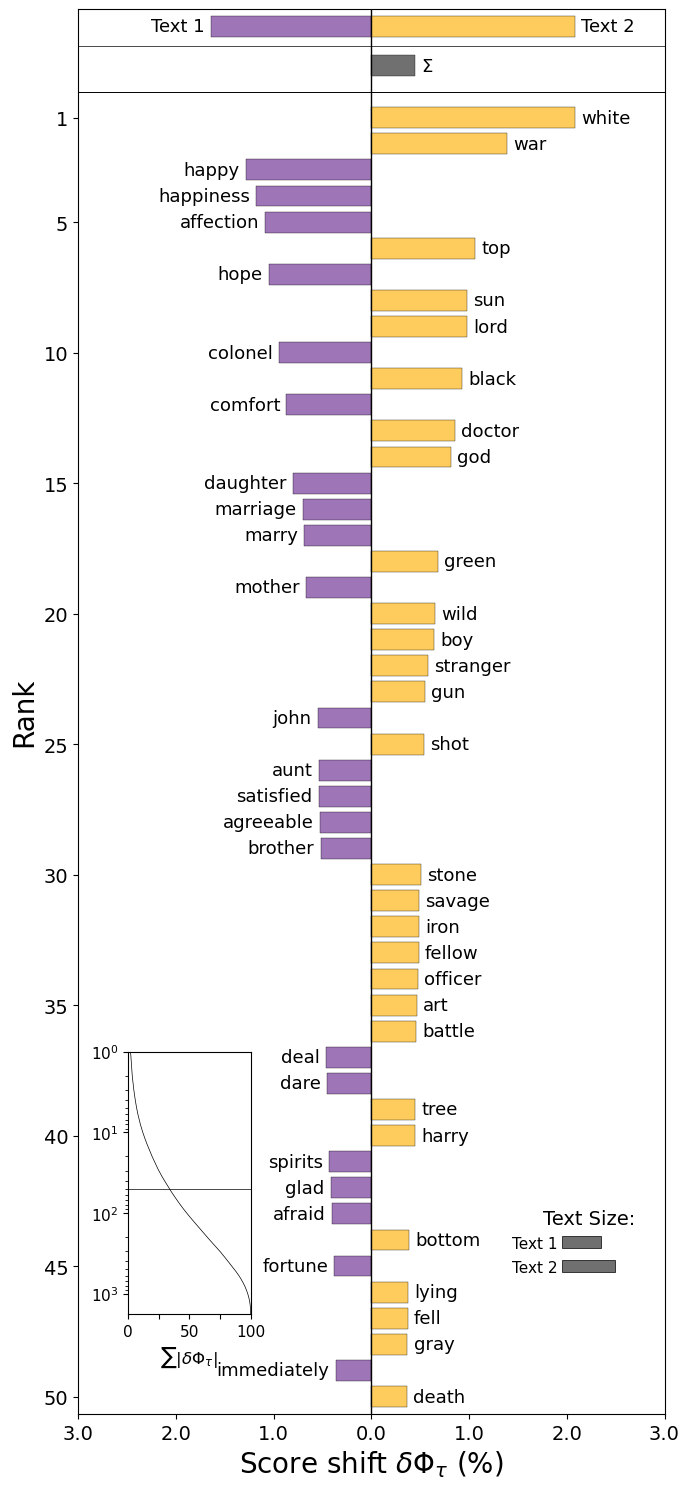

In [262]:
sh.JSDivergenceShift(AFREQ, MFREQ).get_shift_graph();

In [255]:
# sh.JSDivergenceShift(MFREQ, AFREQ).get_shift_graph();

In [256]:
# sh.KLDivergenceShift(AFREQ, MFREQ).get_shift_graph();

In [257]:
# sh.EntropyShift(AFREQ, MFREQ).get_shift_graph();

## By Sentiment

In [258]:
# sh.Shift?

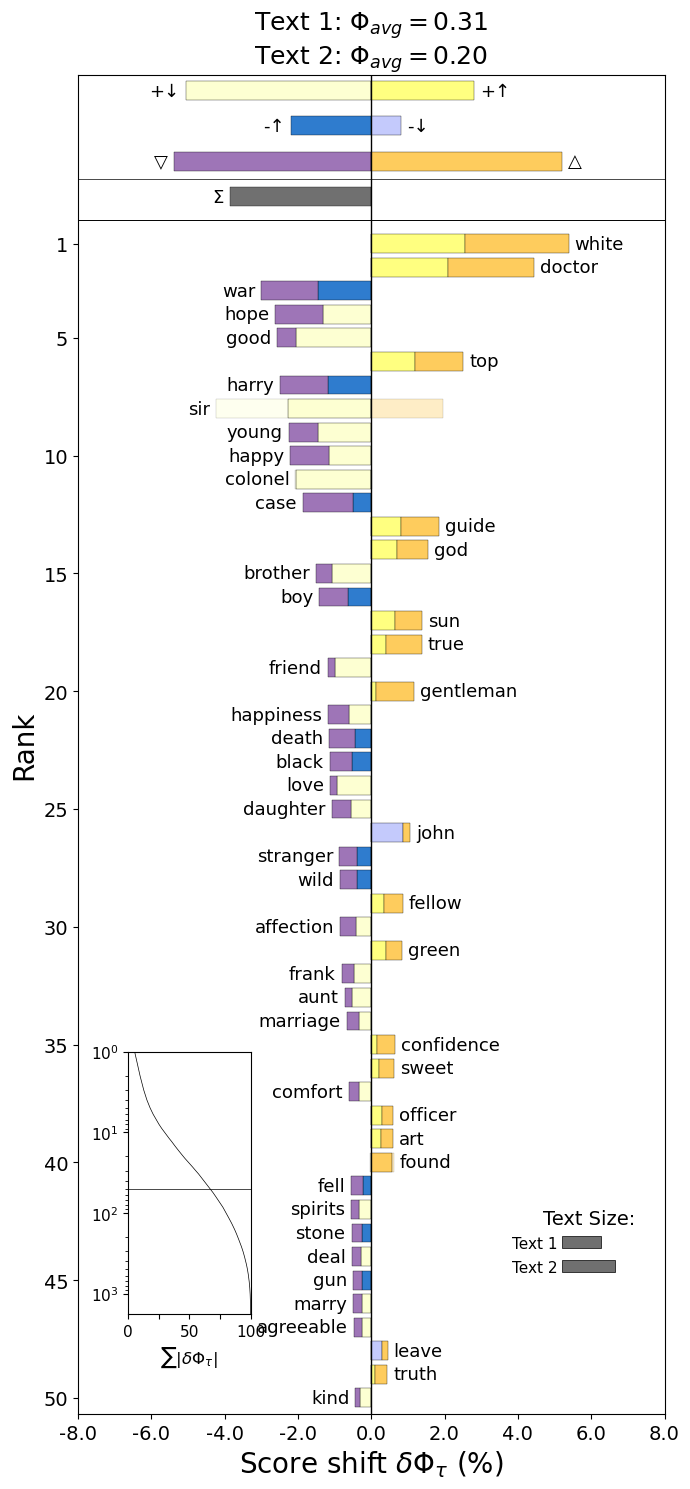

In [259]:
sh.Shift(AFREQ, MFREQ, ASENTW, MSENTW).get_shift_graph();

See https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-021-00260-3

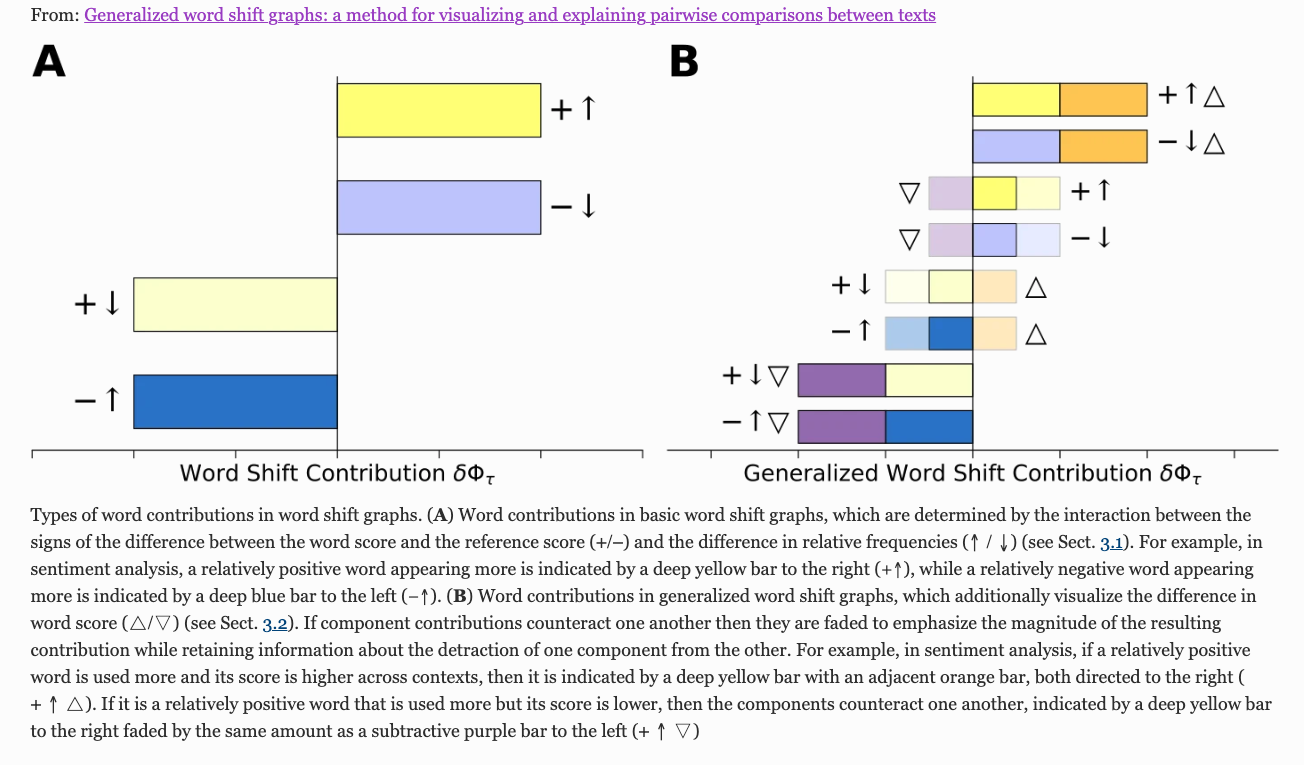

# Compare Terms 

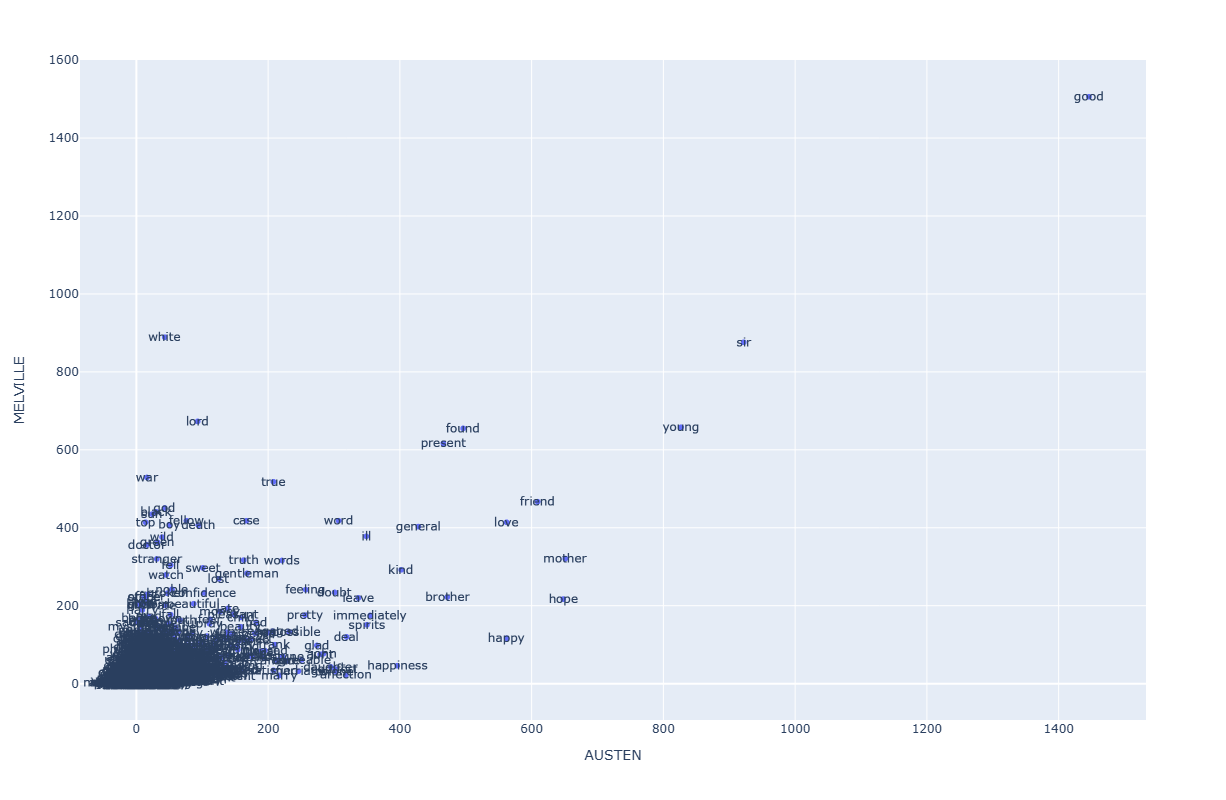

In [220]:
px.scatter(FREQ.reset_index(), 
           'AUSTEN', 'MELVILLE', 
           hover_name='term_str',
           text='term_str',
           height=800, width=900)

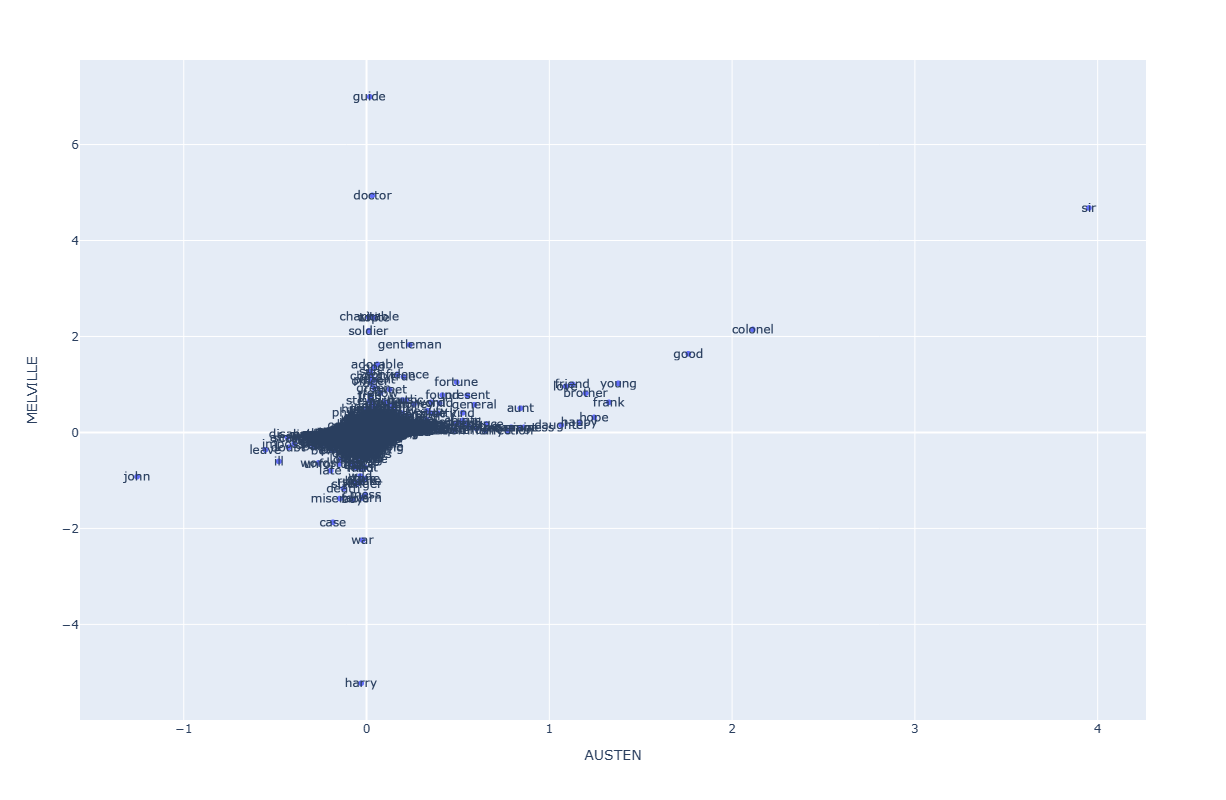

In [219]:
px.scatter(SENTW.reset_index(), 
           'AUSTEN', 'MELVILLE', 
           hover_name='term_str',
           text='term_str',
           height=800, width=900)

# Use to Compare Topics

In [183]:
PHI = pd.read_csv(f"{output_dir}/{corpus_prefix}-LDA_PHI-40.csv").set_index('topic_id').T
PHI.index.name = 'term_str'

In [184]:
PHI['TSUM'] = PHI.sum(1)

In [185]:
PHIP = PHI / PHI.sum()

In [186]:
PHIP.TSUM

term_str
abbey         0.000105
abhorrence    0.000105
abilities     0.000121
aboard        0.000131
abode         0.000166
                ...   
youll         0.000061
young         0.000096
youth         0.000654
youths        0.000086
zeal          0.000102
Name: TSUM, Length: 4000, dtype: float64

In [187]:
def plot_shift(v1, v2):
    sh.EntropyShift(PHIP[v1].to_dict(), PHIP[v2].to_dict()).get_shift_graph()

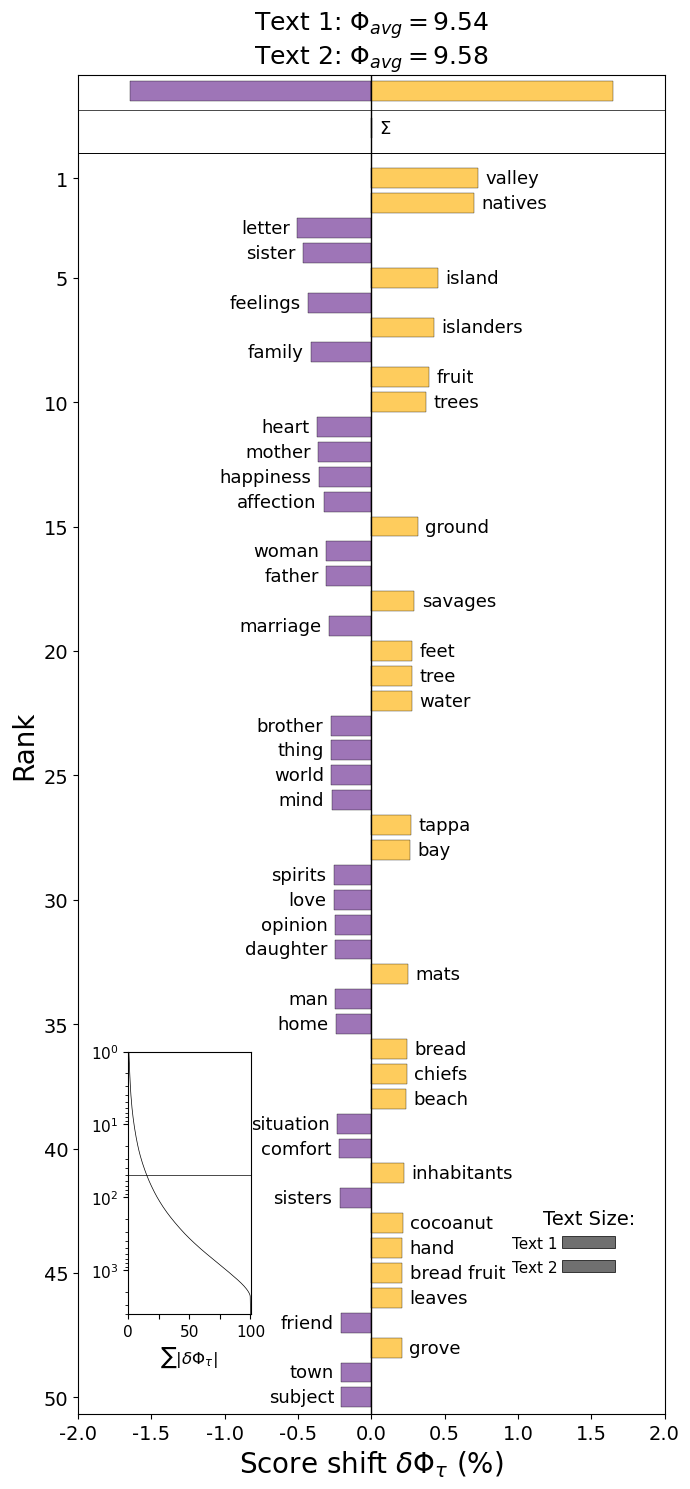

In [188]:
plot_shift('T23', 'T05')